## EthKL Deepfake Detector Notebook

In [104]:
import os
import json
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

# Load the Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

class VideoDataset(Dataset):
    def __init__(self, video_folder, metadata_file, num_frames, transform=None, video_keys=None, limit=None):
        self.video_folder = video_folder
        self.transform = transform
        self.num_frames = num_frames
        self.video_keys = video_keys
        
        # Load metadata
        with open(metadata_file, 'r') as f:
            self.metadata = json.load(f)
            
        # Apply limit to video keys if specified
        if limit:
            self.video_keys = self.video_keys[:limit]

    def __len__(self):
        return len(self.video_keys)

    def __getitem__(self, idx):
        video_name = self.video_keys[idx]
        label = 1 if self.metadata[video_name]['label'] == "FAKE" else 0

        video_path = os.path.join(self.video_folder, video_name)
        cap = cv2.VideoCapture(video_path)

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Calculate frame indices to extract evenly
        frame_indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)
        frames = []

        for frame_idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)  # Set the frame position
            ret, frame = cap.read()
            if ret:
                # Convert frame to grayscale for face detection
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                # Detect faces in the frame
                faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

                if len(faces) > 0:
                    (x, y, w, h) = faces[0]  # Get the first detected face
                    frame = frame[y:y+h, x:x+w]  # Crop the face
                    
                    # Convert BGR to RGB
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    
                    # If frame is mostly black, skip it
                    if np.mean(frame) < 75:
                        continue

                    if self.transform:
                        frame = self.transform(frame)
                        
                    frames.append(frame)
            else:
                break
        
        cap.release()

        # If fewer valid frames were read, duplicate the last frame until the required number is reached
        while len(frames) < self.num_frames:
            if frames:  # Check if there's at least one valid frame
                frames.append(frames[-1])  # Duplicate the last valid frame
            else:
                frames.append(torch.zeros((3, 224, 224)))  # Add empty frame if no valid frame

        return torch.stack(frames), label

In [105]:
import matplotlib.pyplot as plt

# Function to visualize sample frames
def show_sample_frames(frames, labels, video_keys):
    # Iterate through the batch
    for i in range(frames.size(0)):  # Iterate through each video in the batch
        plt.figure(figsize=(12, 6))
        plt.suptitle(f'Video Key: {video_keys[i]} | Video Label: {labels[i].item()}')
        
        # Plot each frame in the video
        for j in range(frames.size(1)):  # Iterate through the frames of the video
            plt.subplot(4, 8, j + 1)  # 4 rows, 8 columns
            frame = frames[i][j].permute(1, 2, 0).numpy()  # Change shape to (H, W, C)
            plt.imshow(frame)
            plt.axis('off')  # Hide axes

        plt.show()  # Show the plots

In [109]:
import json
LIMIT = 30
real_keys_limit = int(LIMIT / 2)

def extract_video_keys(metadata_file, limit):
    # Load metadata
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)

    # Lists to store REAL and FAKE keys
    real_keys = []
    fake_keys = []

    # Separate keys based on label
    for video_key, info in metadata.items():
        if info['label'] == 'REAL':
            real_keys.append(video_key)
        elif info['label'] == 'FAKE':
            fake_keys.append(video_key)

    # Combine REAL keys with FAKE keys until the limit is reached
    # maximum 500 real keys
    if len(real_keys) > real_keys_limit:
        real_keys = real_keys[:real_keys_limit]
    selected_keys = real_keys.copy()
    remaining_limit = limit - len(selected_keys)

    if remaining_limit > 0:
        selected_keys.extend(fake_keys[:remaining_limit])  # Add FAKE keys if needed

    return real_keys, fake_keys, selected_keys

# Usage
metadata_file = "../dataset/dfdc_train_part_49/dfdc_train_part_49/metadata.json"
real_keys, fake_keys, video_keys = extract_video_keys(metadata_file, LIMIT)

# Check the number of keys extracted
print(f"Total number of video keys extracted: {len(video_keys)}")
print(f"Number of REAL videos: {len(real_keys)}")
print(f"Number of FAKE videos: {len(video_keys) - len(real_keys)}")


Total number of video keys extracted: 30
Number of REAL videos: 15
Number of FAKE videos: 15


In [110]:
# Video folder and metadata file
video_folder = "../dataset/dfdc_train_part_49/dfdc_train_part_49"
metadata_file = f"{video_folder}/metadata.json"

# Create the dataset with a limit of 1000 videos
with open(metadata_file, 'r') as f:
    metadata = json.load(f)

# Split video keys into train and test sets
train_keys, test_keys = train_test_split(video_keys, test_size=0.3, random_state=42, stratify=[metadata[key]['label'] for key in video_keys])

# Define transformation for the frames
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets for training and testing
train_dataset = VideoDataset(video_folder=video_folder, metadata_file=metadata_file, num_frames=30, transform=transform, video_keys=train_keys)
test_dataset = VideoDataset(video_folder=video_folder, metadata_file=metadata_file, num_frames=30, transform=transform, video_keys=test_keys)

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Example of iterating through the training DataLoader
for frames, labels in train_loader:
    print("Printing training batch:")
    print(frames.shape)  # Should print (batch_size, num_frames, channels, height, width)
    print(labels)
    # show_sample_frames(frames, labels, train_dataset.video_keys)
    
for frames, labels in test_loader:
    print("Printing testing batch:")
    print(frames.shape)  # Should print (batch_size, num_frames, channels, height, width)
    print(labels)
    # show_sample_frames(frames, labels, test_dataset.video_keys)

Printing training batch:
torch.Size([4, 30, 3, 224, 224])
tensor([0, 0, 0, 1])
Printing training batch:
torch.Size([4, 30, 3, 224, 224])
tensor([0, 1, 1, 0])
Printing training batch:
torch.Size([4, 30, 3, 224, 224])
tensor([1, 1, 1, 1])
Printing training batch:
torch.Size([4, 30, 3, 224, 224])
tensor([1, 0, 0, 0])
Printing training batch:
torch.Size([4, 30, 3, 224, 224])
tensor([0, 0, 0, 1])
Printing training batch:
torch.Size([4, 30, 3, 224, 224])
tensor([1, 1, 0, 1])
Printing testing batch:
torch.Size([4, 30, 3, 224, 224])
tensor([0, 1, 0, 1])
Printing testing batch:
torch.Size([2, 30, 3, 224, 224])
tensor([0, 1])


In [119]:
print(train_keys)

['teffiqocch.mp4', 'obutchbzkp.mp4', 'razacdewcv.mp4', 'bdsxxaamze.mp4', 'vhyvttctxs.mp4', 'tigrqefect.mp4', 'rkbxybizvj.mp4', 'okgoflrwph.mp4', 'qcyjwpyzre.mp4', 'mfcfhhxzif.mp4', 'wnfqtbneoe.mp4', 'puayaegfzc.mp4', 'tfceaqvefa.mp4', 'nfjfylwjvj.mp4', 'dwwytkheyx.mp4', 'syfzjjdmxh.mp4', 'mmffoscwcq.mp4', 'tmvqmdzyln.mp4', 'sqqamveljk.mp4', 'jvlvkijuwa.mp4', 'nlcqykqsdp.mp4', 'rgksdbawuc.mp4', 'fakfkpzenm.mp4', 'tgbjtksars.mp4']


In [111]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CNNLSTM(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.lstm = nn.LSTM(128 * 28 * 28, 256, batch_first=True)  # Adjust input size based on CNN output
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        batch_size, num_frames, c, h, w = x.size()
        # Reshape for CNN
        x = x.view(-1, c, h, w)
        x = self.cnn(x)
        x = x.view(batch_size, num_frames, -1)  # Shape to (batch_size, num_frames, features)
        x, _ = self.lstm(x)  # Apply LSTM
        x = x[:, -1, :]  # Get the output of the last frame
        x = self.fc(x)  # Final output
        return x

In [112]:
# Train Step Function
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for frames, labels in tqdm(dataloader, leave=False):
        frames, labels = frames.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(frames)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = correct / total

    return epoch_loss, epoch_accuracy


# Test Step Function
def test_step(model, dataloader, loss_fn, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for frames, labels in tqdm(dataloader, leave=False):
            frames, labels = frames.to(device), labels.to(device)

            # Forward pass
            outputs = model(frames)
            loss = loss_fn(outputs, labels)

            # Calculate predictions
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect loss for validation
            running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = correct / total

    return epoch_loss, epoch_accuracy

In [113]:
# Train Function
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          loss_fn: torch.nn.Module,
          epochs: int) -> dict:
    
    # 1. Create empty results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 2. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs), desc="Epochs"):  # use tqdm to show a progress bar
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )

        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        # 3. Print out what's happening
        print(
            f"Epoch: {epoch + 1}/{epochs} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 4. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 5. Return the filled results at the end of the epochs
    return results

In [114]:
import matplotlib.pyplot as plt

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss function, and optimizer
model = CNNLSTM(num_classes=2).to(device)  
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Number of epochs
NUM_EPOCHS = 20

# Move the model to the appropriate device
model = model.to(device)

# Train the model and get results
results = train(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    device=device,
    loss_fn=loss_fn, 
    epochs=NUM_EPOCHS
)

Epochs:   5%|▌         | 1/20 [02:45<52:33, 165.99s/it]

Epoch: 1/20 | train_loss: 0.8877 | train_acc: 0.4167 | test_loss: 0.6921 | test_acc: 0.5000


Epochs:  10%|█         | 2/20 [05:19<47:34, 158.61s/it]

Epoch: 2/20 | train_loss: 0.7736 | train_acc: 0.4167 | test_loss: 0.7300 | test_acc: 0.5000


Epochs:  15%|█▌        | 3/20 [08:03<45:41, 161.29s/it]

Epoch: 3/20 | train_loss: 0.7139 | train_acc: 0.5000 | test_loss: 0.7071 | test_acc: 0.5000


Epochs:  20%|██        | 4/20 [10:58<44:23, 166.45s/it]

Epoch: 4/20 | train_loss: 0.7200 | train_acc: 0.3750 | test_loss: 0.6938 | test_acc: 0.5000


Epochs:  25%|██▌       | 5/20 [13:50<42:09, 168.65s/it]

Epoch: 5/20 | train_loss: 0.6980 | train_acc: 0.2917 | test_loss: 0.6953 | test_acc: 0.3333


Epochs:  30%|███       | 6/20 [16:44<39:43, 170.24s/it]

Epoch: 6/20 | train_loss: 0.7064 | train_acc: 0.5833 | test_loss: 0.7116 | test_acc: 0.5000


Epochs:  35%|███▌      | 7/20 [19:25<36:16, 167.41s/it]

Epoch: 7/20 | train_loss: 0.6873 | train_acc: 0.5000 | test_loss: 0.7165 | test_acc: 0.5000


Epochs:  40%|████      | 8/20 [22:12<33:27, 167.33s/it]

Epoch: 8/20 | train_loss: 0.6753 | train_acc: 0.6250 | test_loss: 0.7464 | test_acc: 0.3333


Epochs:  45%|████▌     | 9/20 [24:53<30:17, 165.23s/it]

Epoch: 9/20 | train_loss: 0.6615 | train_acc: 0.7083 | test_loss: 0.7470 | test_acc: 0.3333


Epochs:  50%|█████     | 10/20 [27:35<27:21, 164.15s/it]

Epoch: 10/20 | train_loss: 0.6385 | train_acc: 0.7083 | test_loss: 0.7868 | test_acc: 0.3333


Epochs:  55%|█████▌    | 11/20 [30:21<24:43, 164.83s/it]

Epoch: 11/20 | train_loss: 0.6184 | train_acc: 0.7917 | test_loss: 0.8221 | test_acc: 0.1667


Epochs:  60%|██████    | 12/20 [33:08<22:02, 165.37s/it]

Epoch: 12/20 | train_loss: 0.6398 | train_acc: 0.6667 | test_loss: 0.7930 | test_acc: 0.3333


Epochs:  65%|██████▌   | 13/20 [35:47<19:05, 163.60s/it]

Epoch: 13/20 | train_loss: 0.6416 | train_acc: 0.5833 | test_loss: 0.7655 | test_acc: 0.5000


Epochs:  70%|███████   | 14/20 [38:39<16:37, 166.17s/it]

Epoch: 14/20 | train_loss: 0.6226 | train_acc: 0.6250 | test_loss: 0.7669 | test_acc: 0.5000


Epochs:  75%|███████▌  | 15/20 [41:24<13:48, 165.77s/it]

Epoch: 15/20 | train_loss: 0.5929 | train_acc: 0.6667 | test_loss: 0.7571 | test_acc: 0.5000


Epochs:  80%|████████  | 16/20 [44:13<11:07, 166.76s/it]

Epoch: 16/20 | train_loss: 0.5804 | train_acc: 0.7083 | test_loss: 0.7327 | test_acc: 0.3333


Epochs:  85%|████████▌ | 17/20 [47:05<08:24, 168.20s/it]

Epoch: 17/20 | train_loss: 0.5205 | train_acc: 0.7500 | test_loss: 0.7540 | test_acc: 0.5000


Epochs:  90%|█████████ | 18/20 [49:49<05:33, 166.99s/it]

Epoch: 18/20 | train_loss: 0.4876 | train_acc: 0.8750 | test_loss: 0.7701 | test_acc: 0.1667


Epochs:  95%|█████████▌| 19/20 [52:31<02:45, 165.61s/it]

Epoch: 19/20 | train_loss: 0.4945 | train_acc: 0.8333 | test_loss: 0.7896 | test_acc: 0.3333


Epochs: 100%|██████████| 20/20 [55:23<00:00, 166.18s/it]

Epoch: 20/20 | train_loss: 0.4676 | train_acc: 0.8333 | test_loss: 0.7549 | test_acc: 0.5000


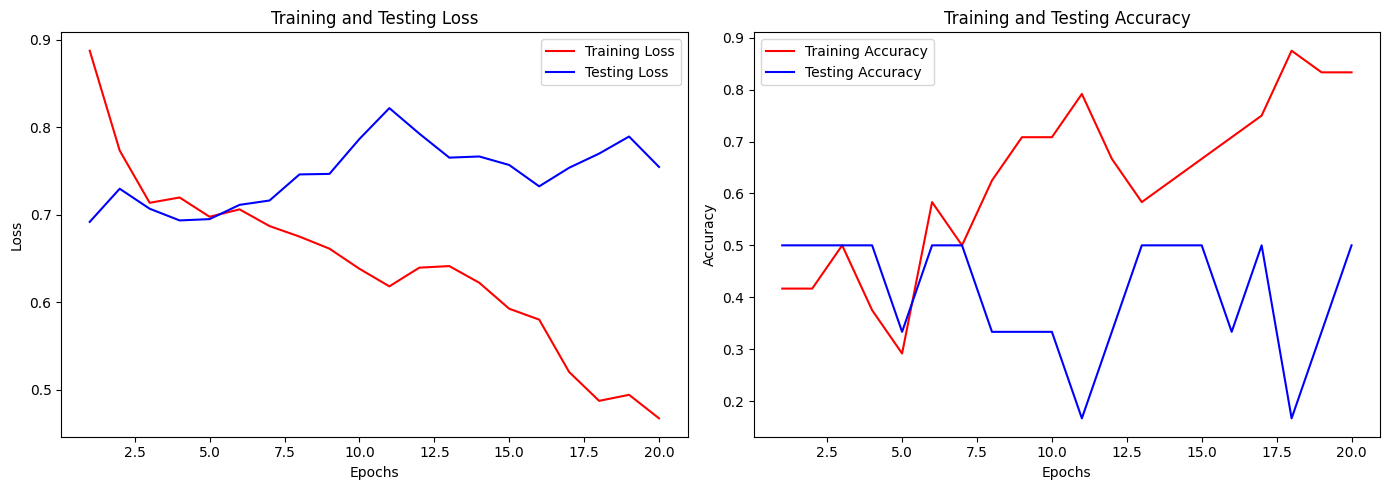

<Figure size 640x480 with 0 Axes>

In [120]:
# Plotting function
def plot_training_results(results):
    # Extract loss and accuracy
    train_loss = results["train_loss"]
    train_acc = results["train_acc"]
    test_loss = results["test_loss"]
    test_acc = results["test_acc"]

    # Set up the plots
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 5))

    # Plot training and testing loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, test_loss, 'b', label='Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss')
    plt.legend()

    # Plot training and testing accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
    plt.plot(epochs, test_acc, 'b', label='Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()
    
    # save the plot
    plt.savefig('training_results.png')

# Call the plot function to visualize the training results
plot_training_results(results)

In [117]:
def save_model_weights(model, file_path):
    """Save model weights to a .pt file."""
    torch.save(model.state_dict(), file_path)
    print(f"Model weights saved to {file_path}")
    
def load_model_weights(model, file_path):
    """Load model weights from a .pt file."""
    model.load_state_dict(torch.load(file_path))
    model.eval()  # Set the model to evaluation mode
    print(f"Model weights loaded from {file_path}")

In [118]:
model_dir = "../model"

# if dir not exist, create it
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_name = "ethkl_cnn_lstm_vid_30_epochs_20.pt"
path = os.path.join(model_dir, model_name)  
save_model_weights(model, path)

# Then load the weights into this instance
# load_model_weights(model, path)

Model weights saved to ../model\ethkl_cnn_lstm_vid_30_epochs_20.pt
